In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# create directory for kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# dowload dataset
!kaggle datasets download -d deadskull7/fer2013

 84% 81.0M/96.6M [00:01<00:00, 59.6MB/s]
100% 96.6M/96.6M [00:01<00:00, 68.6MB/s]


In [5]:
# unzip dataset
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [6]:
# Import libraries
import csv
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
%matplotlib inline

In [7]:
# dataset
data_path = '/content/files/fer2013.csv'

# Class for Loading  dataset

In [12]:
class FacialEmotionDataset(Dataset):
    
    def __init__(self, images=None, emotions=None, transform=None):
        self.images = images
        self.emotions = emotions
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion
    

class DatasetFactory:
    
    def __init__(self):
        self.images = []
        self.emotions = []
        self.val_images = []
        self.val_emotions = []
        self.test_images = []
        self.test_emotions = []
        
        with open(data_path, 'r') as file:
            data = csv.reader(file)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype(np.uint8)
                
                if row[-1] == 'Training':
                    self.images.append(Image.fromarray(face))
                    self.emotions.append(int(row[0]))
                
                if row[-1] == 'PrivateTest':
                    self.val_images.append(Image.fromarray(face))
                    self.val_emotions.append(int(row[0]))
                    
                if row[-1] == 'PublicTest':
                    self.test_images.append(Image.fromarray(face))
                    self.test_emotions.append(int(row[0]))
                
        print(f'Training size: {len(self.images)}, \nTest size: {len(self.test_images)},\nValidation size: {len(self.val_images)}')

In [13]:
factory = DatasetFactory()

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor()
                                ])
 
val_transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

training = FacialEmotionDataset(factory.images, factory.emotions, train_transform)
validation = FacialEmotionDataset(factory.val_images, factory.val_emotions, val_transform)
testing = FacialEmotionDataset(factory.test_images, factory.test_emotions, val_transform)

Training size: 28709, 
Test size: 3589,
Validation size: 3589


# DataLoader

In [14]:
train_loader = DataLoader(training, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing, batch_size=32)

# Display images

images.shape:  torch.Size([64, 1, 48, 48])


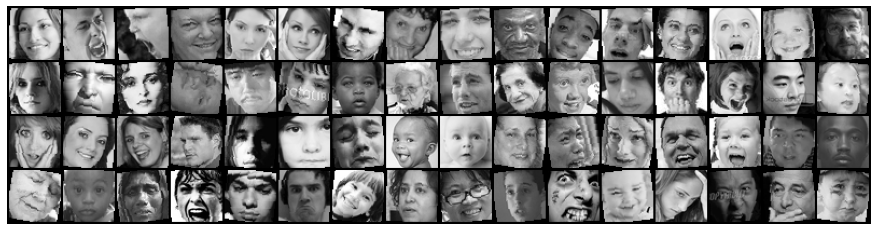

In [15]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [16]:
from collections import defaultdict

# First Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20*9*9, 500)
        self.fc2 = nn.Linear(500, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 7)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.float()), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [ ]:
def fit(epoch, model, data_loader, optimizer, phase):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
    
    running_loss = 0.0
    running_correct = 0.0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        torch.cuda.empty_cache()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()  

        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        running_loss += criterion(output, target).item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase == 'training':
            loss.backward()
            optimizer.step()
        loss = running_loss / len(data_loader.dataset)

        accuracy = 100. * running_correct/len(data_loader.dataset)
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

In [ ]:
# # Instantiate model
# model = Net()
# device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# # model optimizer - optimizes model's parameters
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Second Architecture

In [ ]:
class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d (32, 64, kernel_size=3)
        self.conv3 =  nn.Conv2d(64, 128, kernel_size=2)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc4 = nn.Linear(128*3*3, 1000)
        self.fc5 = nn.Linear(1000, 700)
        self.fc6 = nn.Linear(700, 400)
        self.fc7 = nn.Linear(400, 200)
        self.fc8 = nn.Linear(200, 7)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.float()), 4))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv3(x)), 1))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc5(x))
        x = x = F.dropout(x, training=self.training)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc8(x))
        return F.log_softmax(x, dim=1)

# Third Architecture

In [ ]:
class EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(EmotionModel, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d (32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=0.1)
        self.fc3 = nn.Linear(64*4*4, 1000)
        self.fc4 = nn.Linear(1000, 700)
        self.fc5 = nn.Linear(700, 400)
        self.fc6 = nn.Linear(400, 200)
        self.fc7 = nn.Linear(200, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.float()), 4))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        x = x = F.dropout(x, training=self.training)
        x = F.relu(self.fc5(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc7(x))
        return F.log_softmax(x, dim=1)

4th Architecture

In [ ]:
class EmotionModel_4th(nn.Module):
    def __init__(self, num_classes):
        super(EmotionModel_4th, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 96, kernel_size=2, stride=2)
        self.norm1 = nn.BatchNorm2d(96, affine=True, momentum=0.99, eps=1e-3)
        self.conv2 = nn.Conv2d (96, 256, kernel_size=2, stride=2)
        self.norm2 = nn.BatchNorm2d(256, affine=True, momentum=0.99, eps=1e-3)
        self.conv2_drop = nn.Dropout2d(p=0.1)
        self.fc3 = nn.Linear(256*3*3, 1500)
        self.norm3 = nn.BatchNorm1d(1500, momentum=0.99, eps=1e-3, affine=True)
        self.fc4 = nn.Linear(1500, 1000)
        self.norm4 = nn.BatchNorm1d(1000, momentum=0.99, eps=1e-3)
        self.out = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.norm1(F.relu(F.max_pool2d(self.conv1(x.float()), 2)))
        x = self.norm2(F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)))
        x = x.view(x.size(0), -1)
        x = self.norm3(F.relu(self.fc3(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.norm4(F.relu(self.fc4(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.relu(self.out(x))
        return F.log_softmax(x, dim=1)

In [ ]:
class EmotionModel_5th(nn.Module):
    def __init__(self, num_classes):
        super(EmotionModel_5th, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d (96, 192, kernel_size=3, stride=2)
        self.conv2_drop = nn.Dropout2d(p=0.1)
        self.fc3 = nn.Linear(192*2*2, 384)
        self.fc4 = nn.Linear(384, 1152)
        self.fc5 = nn.Linear(1152, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.float()), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.relu(self.fc4(x))
        x = x = F.dropout(x, training=self.training, p=0.1)
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [ ]:
class EmotionModel_6th(nn.Module):
    def __init__(self, num_classes):
        super(EmotionModel_6th, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 96, kernel_size=2, stride=2)
        self.norm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d (96, 256, kernel_size=2, stride=2)
        self.norm2 = nn.BatchNorm2d(256)
        self.conv2_drop = nn.Dropout2d(p=0.1)
        self.fc3 = nn.Linear(256*3*3, 1500)
        self.norm3 = nn.BatchNorm1d(1500)
        self.fc4 = nn.Linear(1500, 1000)
        self.norm4 = nn.BatchNorm1d(1000)
        self.fc5 = nn.Linear(1000, num_classes)
 
    def forward(self, x):
        x = self.norm1(F.relu(F.max_pool2d(self.conv1(x.float()), 2)))
        x = self.norm2(F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)))
        x = x.view(x.size(0), -1)
        x = self.norm3(F.relu(self.fc3(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.norm4(F.relu(self.fc4(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [ ]:
# Instantiate model
torch.cuda.empty_cache()
model = EmotionModel_4th(7)
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.99)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
epochs = 35
history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = fit(epochs, model, train_loader, optimizer, 'training')
    val_loss, val_accuracy = fit(epochs, model, validation_loader, optimizer, 'validation')
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

Epoch 1/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 2/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 3/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 4/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 5/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 6/35
training loss is  0.03 and training accuracy is 3995.0/(28709     13.92
validation loss is 0.031 and validation accuracy is 491.0/(3589     13.68
Epoch 7/35
training loss is  0.03 and training accuracy is

# Test

In [ ]:
resnet = torchvision.models.resnet18()

In [ ]:
model_path = '/content/drive/MyDrive/ferclassifier.pt'

model = torch.load(model_path, )

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
def test_accuracy(model, criterion, data_loader):
  test_preds = []
  test_labels = []

  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, labels in data_loader:
      torch.cuda.empty_cache()
      model = model.eval()
      data, labels = data.to(device), labels.to(device)
      outputs = model(data)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)
      
      test_preds.append(preds.cpu().numpy())
      test_labels.append(labels.cpu().numpy())

      running_correct += torch.sum(preds == labels)
      running_loss += loss.item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  
  test_preds = np.concatenate(np.array(test_preds))
  test_labels = np.concatenate(np.array(test_labels))

  return test_preds, test_labels